In [30]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
#import os
#os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
#os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [32]:
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD
from keras.optimizers import Adam
from keras.metrics import top_k_categorical_accuracy
import math
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import matplotlib.pyplot as plt
from keras.callbacks import TensorBoard
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
#from keras.utils import multi_gpu_model

In [33]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11039642355834768413
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 163381248
locality {
  bus_id: 1
}
incarnation: 5836695865545652581
physical_device_desc: "device: 0, name: GeForce GTX 970, pci bus id: 0000:05:00.0, compute capability: 5.2"
]


In [34]:
train_data_dir = "train"
val_data_dir = "test"
img_width = 180
img_height = 180
#classnames = pickle.load(open("/path/to/val/", "rb"))
batch_size = 64   # 258
train_size = 1192270
test_size = 132499

In [35]:
# Data generator
train_datagen = ImageDataGenerator(
        rescale=1./255,
        zoom_range=0.1,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True)

train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size = (img_width, img_height),
        batch_size = batch_size,
        shuffle = True,
        class_mode = 'categorical')

val_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = val_datagen.flow_from_directory(
        val_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        shuffle = True,
        class_mode = 'categorical')

Found 1192270 images belonging to 27 classes.
Found 132499 images belonging to 27 classes.


In [36]:
# create the base pre-trained model
base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_tensor=None, input_shape=(img_width, img_height, 3))

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D(name='avg_pool')(x)

# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)

x = Dropout(0.1)(x)

# and a logistic layer -- let's say we have 200 classes

predictions = Dense(27, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
#model.compile(optimizer='rmsprop', loss='categorical_crossentropy')



# Replicates `model` on 4 GPUs.
# This assumes that your machine has 4 available GPUs.
#model = multi_gpu_model(model, gpus=4)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[top_k_categorical_accuracy, 'accuracy'])




In [37]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=1, min_lr=0.00001)
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=3, verbose=0, mode='auto')

filepath="weights.best.hdf5"

checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
tbd = TensorBoard(log_dir='./logs',  batch_size=batch_size, write_graph=True )

In [38]:
# train the model on the new data for a few epochs
history = model.fit_generator(generator=train_generator,
                         steps_per_epoch = 7000,
                         epochs = 10,
                         use_multiprocessing=False,
                         max_queue_size=10,
                         workers = 8,     
                         validation_data = validation_generator,
                         callbacks=[tbd, checkpoint, earlystop ],
                         validation_steps = math.ceil(test_size  / batch_size))
# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from inception V3. We will freeze the bottom N layers
# and train the remaining top layers.

Epoch 1/10
7000/7000 [==============================] - 4000s 571ms/step - loss: 1.8848 - top_k_categorical_accuracy: 0.7743 - acc: 0.4612 - val_loss: 1.6562 - val_top_k_categorical_accuracy: 0.8167 - val_acc: 0.5265
Epoch 2/10
7000/7000 [==============================] - 3894s 556ms/step - loss: 1.7015 - top_k_categorical_accuracy: 0.8069 - acc: 0.5134 - val_loss: 1.5596 - val_top_k_categorical_accuracy: 0.8335 - val_acc: 0.5536
Epoch 3/10
7000/7000 [==============================] - 3888s 555ms/step - loss: 1.6354 - top_k_categorical_accuracy: 0.8172 - acc: 0.5317 - val_loss: 1.5147 - val_top_k_categorical_accuracy: 0.8380 - val_acc: 0.5690
Epoch 4/10
7000/7000 [==============================] - 3887s 555ms/step - loss: 1.5982 - top_k_categorical_accuracy: 0.8225 - acc: 0.5428 - val_loss: 1.4749 - val_top_k_categorical_accuracy: 0.8453 - val_acc: 0.5821
Epoch 5/10
7000/7000 [==============================] - 3887s 555ms/step - loss: 1.5746 - top_k_categorical_accuracy: 0.8257 - acc: 

dict_keys(['val_loss', 'val_top_k_categorical_accuracy', 'val_acc', 'loss', 'top_k_categorical_accuracy', 'acc'])


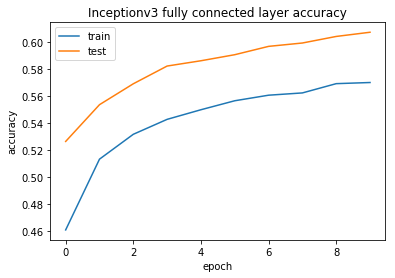

In [39]:
print(history.history.keys())
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Inceptionv3 fully connected layer accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [40]:
#SVG(model_to_dot(model).create(prog='dot', format='svg'))

# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model.layers[:727]:
   layer.trainable = False
for layer in model.layers[727:]:
   layer.trainable = True


0 input_4
1 conv2d_610
2 batch_normalization_610
3 activation_610
4 conv2d_611
5 batch_normalization_611
6 activation_611
7 conv2d_612
8 batch_normalization_612
9 activation_612
10 max_pooling2d_13
11 conv2d_613
12 batch_normalization_613
13 activation_613
14 conv2d_614
15 batch_normalization_614
16 activation_614
17 max_pooling2d_14
18 conv2d_618
19 batch_normalization_618
20 activation_618
21 conv2d_616
22 conv2d_619
23 batch_normalization_616
24 batch_normalization_619
25 activation_616
26 activation_619
27 average_pooling2d_4
28 conv2d_615
29 conv2d_617
30 conv2d_620
31 conv2d_621
32 batch_normalization_615
33 batch_normalization_617
34 batch_normalization_620
35 batch_normalization_621
36 activation_615
37 activation_617
38 activation_620
39 activation_621
40 mixed_5b
41 conv2d_625
42 batch_normalization_625
43 activation_625
44 conv2d_623
45 conv2d_626
46 batch_normalization_623
47 batch_normalization_626
48 activation_623
49 activation_626
50 conv2d_622
51 conv2d_624
52 conv2d_6

In [41]:
model.save_weights('model_wpart.h5') 

In [42]:
# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
model.compile(loss='categorical_crossentropy', optimizer=SGD(lr=0.001, momentum=0.9), 
              metrics=[top_k_categorical_accuracy, 'accuracy'])
# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
history1 = model.fit_generator(generator=train_generator,
                         steps_per_epoch = 7000,
                         epochs = 10,
                         use_multiprocessing=False,
                         max_queue_size=10,
                         workers = 16,                                  
                         validation_data = validation_generator,
                         callbacks=[tbd, checkpoint, earlystop, reduce_lr ],
                         validation_steps = math.ceil(test_size / batch_size))

Epoch 1/10
7000/7000 [==============================] - 4099s 586ms/step - loss: 1.3179 - top_k_categorical_accuracy: 0.8675 - acc: 0.6193 - val_loss: 1.1875 - val_top_k_categorical_accuracy: 0.8870 - val_acc: 0.6631
Epoch 2/10
7000/7000 [==============================] - 4101s 586ms/step - loss: 1.2296 - top_k_categorical_accuracy: 0.8802 - acc: 0.6442 - val_loss: 1.1234 - val_top_k_categorical_accuracy: 0.8950 - val_acc: 0.6788
Epoch 3/10
7000/7000 [==============================] - 4102s 586ms/step - loss: 1.1738 - top_k_categorical_accuracy: 0.8889 - acc: 0.6598 - val_loss: 1.0959 - val_top_k_categorical_accuracy: 0.8992 - val_acc: 0.6879
Epoch 4/10
7000/7000 [==============================] - 4096s 585ms/step - loss: 1.1348 - top_k_categorical_accuracy: 0.8948 - acc: 0.6694 - val_loss: 1.0697 - val_top_k_categorical_accuracy: 0.9023 - val_acc: 0.6953
Epoch 5/10
7000/7000 [==============================] - 4104s 586ms/step - loss: 1.1108 - top_k_categorical_accuracy: 0.8975 - acc: 

dict_keys(['val_loss', 'val_top_k_categorical_accuracy', 'val_acc', 'loss', 'top_k_categorical_accuracy', 'acc', 'lr'])


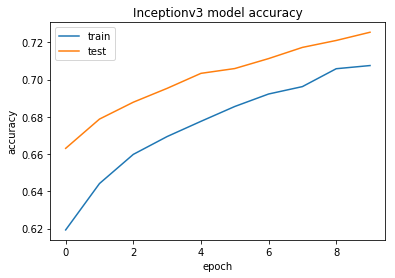

In [43]:
print(history1.history.keys())
plt.plot(history1.history['acc'])
plt.plot(history1.history['val_acc'])
plt.title('Inceptionv3 model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [44]:
model.save_weights('model_wfull.h5') 

ImportError: Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.